# Depression Text Prediction

This project uses natural language processing and machine learning algorithms to predict if a user is depressed based on their text post. The goal of this project is to develop a model that can accurately identify if a user is suffering from depression, which could have important implications for mental health interventions and support.

Import the libraries

In [38]:
import re
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

Load the dataset

In [39]:
df = pd.read_csv("dataset/depression_dataset_reddit_cleaned.csv")
df.head(10)

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1
5,i m year old turning soon in a few month i liv...,1
6,i live alone and despite me being prone to lon...,1
7,i m not looking for sympathy just simply to st...,1
8,i don t know how to communicate all of my thou...,1
9,mom i m sad it hurt in my heart the feeling fa...,1


Shows the summary of the data

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7731 entries, 0 to 7730
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_text     7731 non-null   object
 1   is_depression  7731 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 120.9+ KB


Check is there any missing values

In [41]:
df.isnull().sum()

clean_text       0
is_depression    0
dtype: int64

Check the class distribution

In [66]:
class_dist = df.groupby("is_depression").size()

for index, val in class_dist.items():
    percentage = (val / sum(class_dist) * 100)
    print(f"Class {index} : {val} samples ({percentage:.2f}%)")

Class 0 : 3900 samples (50.45%)
Class 1 : 3831 samples (49.55%)


Create a function to preprocessing the data

In [43]:
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', ''))
    return text

Apply preprocessing to the data

In [44]:
df["clean_text"] = df["clean_text"].apply(preprocessor)

Split the target and feature

In [45]:
X = df["clean_text"]
y = df["is_depression"]

Split the data into train and test set

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

## Model Training

In [47]:
vectorizer = TfidfVectorizer()

In [48]:
model_list = [
    ('Decision Tree' , (Pipeline([('vectorizer' , vectorizer),('DT' ,DecisionTreeClassifier())]))),
    ('KNN' , (Pipeline([('vectorizer' , vectorizer),('KNN' ,KNeighborsClassifier())]))),
    ('Logistic Regression' , (Pipeline([('vectorizer' , vectorizer),('LR' ,LogisticRegression())]))),
    ('SVC' , (Pipeline([('vectorizer' , vectorizer),('SVC' ,SVC())]))),
    ('XGBoost' , (Pipeline([('vectorizer' , vectorizer),('XGB' ,XGBClassifier())])))
    ]

name_list = []
cv_mean_list = []
cv_std_list = []
kfold = KFold(n_splits=10)
for name, model in model_list:
    cv = cross_val_score(model , X_train ,y_train ,cv=kfold , scoring='accuracy', n_jobs=-1)
    name_list.append(name)
    cv_mean_list.append(cv.mean())
    cv_std_list.append(cv.std())
    print(f"{name} trained")

model_results = pd.DataFrame(list(zip(name_list, cv_mean_list, cv_std_list)), columns=['model', 'accuracy', 'stdev'])
model_results.round(3)

Decision Tree trained
KNN trained
Logistic Regression trained
SVC trained
XGBoost trained


,model,accuracy,stdev
0,Decision Tree,0.918,0.013
1,KNN,0.876,0.013
2,Logistic Regression,0.958,0.006
3,SVC,0.964,0.006
4,XGBoost,0.960,0.006


Create a pipeline of TfidVectorizer and SVC

In [49]:
clf_method = SVC()

clf = Pipeline([
     ('vectorizer', vectorizer),
     ('classifier', clf_method)
 ])

Fit the model

In [50]:
clf.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('classifier', SVC())])

Predict the training set

In [51]:
y_train_pred = clf.predict(X_train)

Check the accuracy of the training set prediction

In [52]:
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Accuracy on training set: {train_accuracy:.3f}")

Accuracy on training set: 0.997


In [53]:
cv_accuracy = cross_val_score(clf, X_train, y_train, cv=10)

In [54]:
cv_accuracy.mean()

0.9644237756899896

Shows the classification report of training set

In [55]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3117
           1       1.00      0.99      1.00      3067

    accuracy                           1.00      6184
   macro avg       1.00      1.00      1.00      6184
weighted avg       1.00      1.00      1.00      6184



Visualize the confusion matrix of the training set prediction

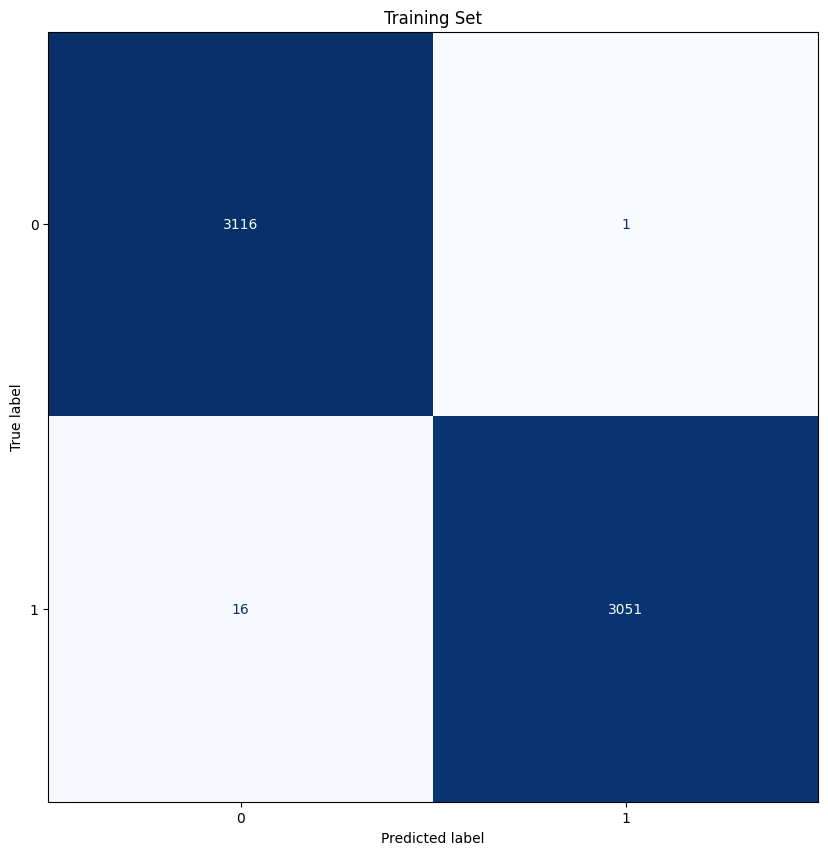

In [56]:
conf_mat_train = ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred))
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Training Set')
conf_mat_train.plot(cmap=plt.cm.Blues, colorbar=False, ax=ax);

## Model Evaluation

Predict the testing set

In [57]:
y_test_pred = clf.predict(X_test)

Check the accuracy of the testing set prediction

In [58]:
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy on testing set: {test_accuracy:.3f}")

Accuracy on testing set: 0.962


Shows the classification report of testing set

In [59]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       783
           1       0.98      0.94      0.96       764

    accuracy                           0.96      1547
   macro avg       0.96      0.96      0.96      1547
weighted avg       0.96      0.96      0.96      1547



Visualize the confusion matrix of the testing set prediction

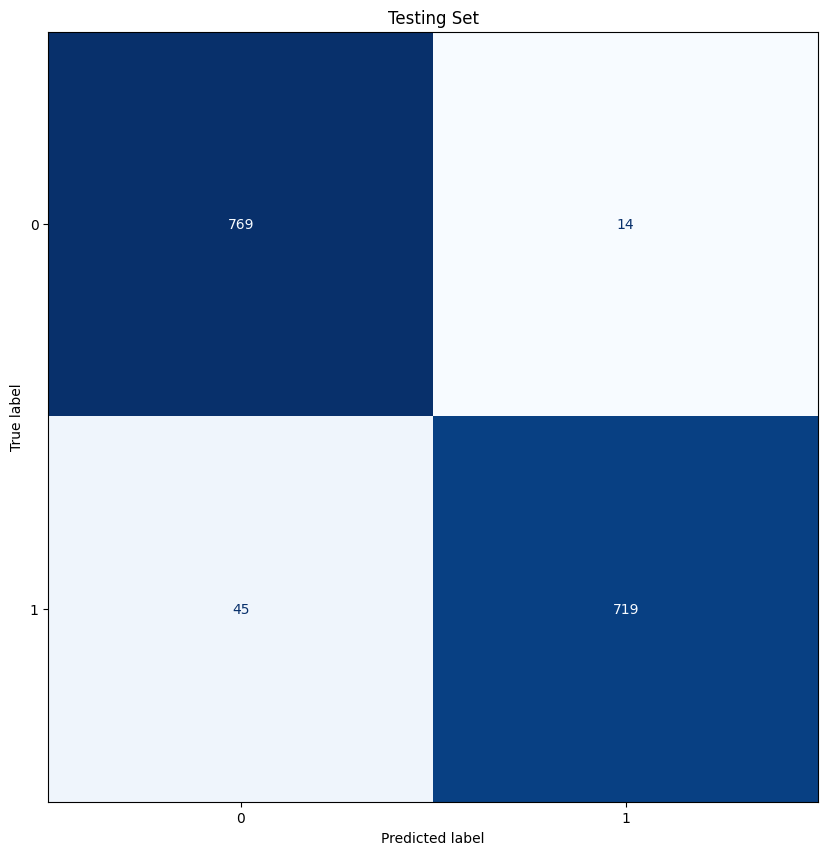

In [60]:
conf_mat_train = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred))
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Testing Set')
conf_mat_train.plot(cmap=plt.cm.Blues, colorbar=False, ax=ax);

## Model Inference

In [61]:
def depression_prediction(model, text):
    sentiment = model.predict(text)
    print(str(text).replace("\\n     ", ''))
    if sentiment == 0:
        output = 'The user is not depressed'
    else:
        output = 'The user is depressed'
    return output

In [62]:
new_text_samples = [
    ["""
     When it's time just let me die, i'm so tired of this life
     """
    ],
    ["""
     Life is beautiful
     """
    ]
]

In [63]:
depression_prediction(clf, new_text_samples[0])

["When it's time just let me die, i'm so tired of this life"]


'The user is depressed'

In [64]:
depression_prediction(clf, new_text_samples[1])

['Life is beautiful']


'The user is not depressed'

## Save the model

In [65]:
import joblib

filename = "model/depression_prediction.sav"
joblib.dump(clf, filename)

['model/depression_prediction.sav']

## Conclusion

In this project, we have succeeded in building a model that is able to predict whether a user is feeling depressed, based on the words used in their posts. A total of 7731 samples used were randomly separated 80% and 20% as training set and testing set, respectively. Based on several models tested, it is known that the SVC model is able to provide the best prediction results, with training accuracy of 99.7%. The 10-fold-cross-validation results also show excellent metrics, with an average accuracy of 96.4%. Testing on the testing set gives an accuracy of 96.2%.